In [1]:
import matplotlib.pyplot as plt
import string 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import nltk

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB

In [3]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/zhu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zhu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zhu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/zhu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
#RELOAD FILE
df=pd.read_csv('cleaned_tweets.csv')  
print(df.shape)

#CONVERT FROM STRING LABELS TO INTEGERS 
labels=[]; #y1=[]; y2=[]
y1=[]
for label in df["label"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y1.append(i)
y1=np.array(y1)

# CONVERT DF TO LIST OF STRINGS 
corpus=df["tweets"].to_list()


print("number of text chunks = ",len(corpus))
print(corpus[0:3])

(10029, 3)
index = 0 : label = 0
index = 1 : label = 1
number of text chunks =  10029
['  no sé si das más pena tú o tu terrible ortografía\x85 pinche naca', ' cuando todo se va al infierno la gente que está a tu lado sin vacilar es tu familia', ' en 1800 nace natturner el esclavo rebelde del sur de estadosunidos ']


In [5]:
# INITIALIZE COUNT VECTORIZER
# minDF = 0.01 means "ignore terms that appear in less than 1% of the documents". 
# minDF = 5 means "ignore terms that appear in less than 5 documents".
vectorizer=CountVectorizer(min_df=0.001)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
Xs  =  vectorizer.fit_transform(corpus)   
X=np.array(Xs.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(X,axis=0)
X=np.ceil(X/maxs)

# DOUBLE CHECK 
print(X.shape,y1.shape)

(10029, 1113) (10029,)


/var/folders/kw/y1wfcqhd7nz_cc11ydrrc7cr0000gn/T/ipykernel_71855/1203232167.py:23: RuntimeWarning: invalid value encountered in double_scalars
  dist=np.dot(vi, vj)/(np.linalg.norm(vi)*np.linalg.norm(vj)) #cosine sim


(250, 250)
[[0.         0.         0.25819889 ... 0.         0.16903085 0.1       ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.25819889 0.         0.         ... 0.         0.21821789 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.16495722 0.09759001]
 [0.16903085 0.         0.21821789 ... 0.16495722 0.         0.16903085]
 [0.1        0.         0.         ... 0.09759001 0.16903085 0.        ]]


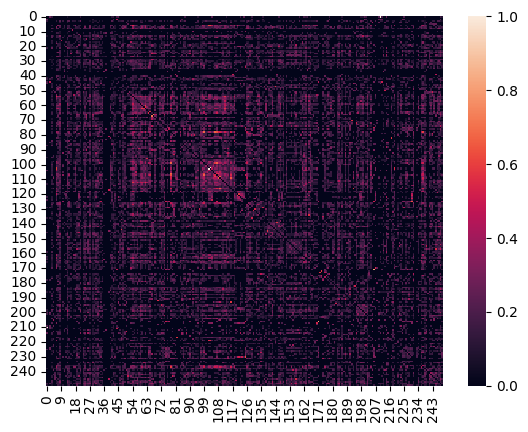

In [6]:
num_rows_keep=250
index=np.sort(np.random.choice(X.shape[0], num_rows_keep, replace=False))
# print(y1[index])
# print(index)
tmp1=X[index, :]
# print(tmp1.shape,tmp1.dtype,tmp1[:,].shape)

#COMPUTE DISTANCE MATRIX
dij=[]

#LOOP OVER ROWS
for i in range(0,tmp1.shape[0]):
    tmp2=[]
    #LOOP OVER ROWS
    for j in range(0,tmp1.shape[0]):

        #EXTRACT VECTORS
        vi=tmp1[i,:]
        vj=tmp1[j,:]
        #print(vi.shape,vj.shape)

        #COMPUTE DISTANCES
        dist=np.dot(vi, vj)/(np.linalg.norm(vi)*np.linalg.norm(vj)) #cosine sim
        #dist=np.linalg.norm(vi-vj) #euclidean

        # BUILD DISTANCE MATRIX
        if(i==j or np.max(vi) == 0 or np.max(vj)==0):
            tmp2.append(0)
        else:
            tmp2.append(dist)
    dij.append(tmp2); #print(dij)
        # raise
dij=np.array(dij)

#normalize
# dij=(dij-np.min(dij))/(np.max(dij)-np.min(dij))

#Lower triangle of an array.
# dij=np.sort(dij,axis=0)
# dij=np.sort(dij,axis=1)
# dij=np.tril(dij, k=-1) 


import seaborn as sns
# sns.heatmap(np.exp(dij), annot=False) #,  linewidths=.05)
heatmap = sns.heatmap(dij, annot=False) #,  linewidths=.05)
heatmap.figure.savefig("heatmap.png")
print(dij.shape)
print(dij)

[0.05152696 0.03284952 0.02594211 0.02397751 0.0224975  0.02129877
 0.01943876 0.01824887 0.01569677 0.01521021]
[62.62769714 50.0050274  44.43772522 42.7219666  41.38246186 40.26488421
 38.46656704 37.27067015 34.5664142  34.02645931]


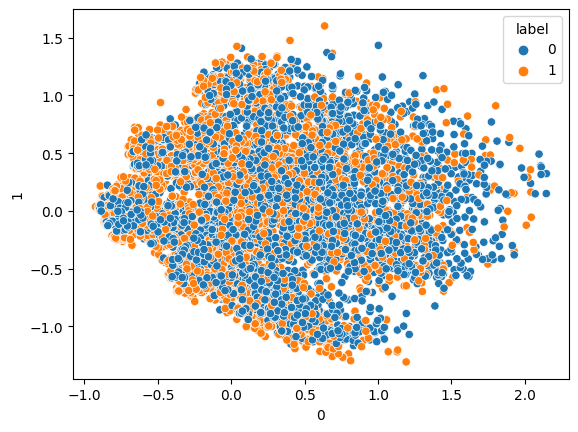

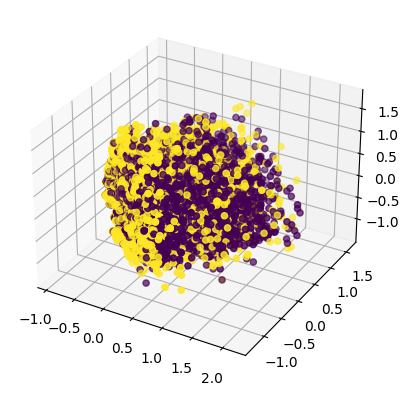

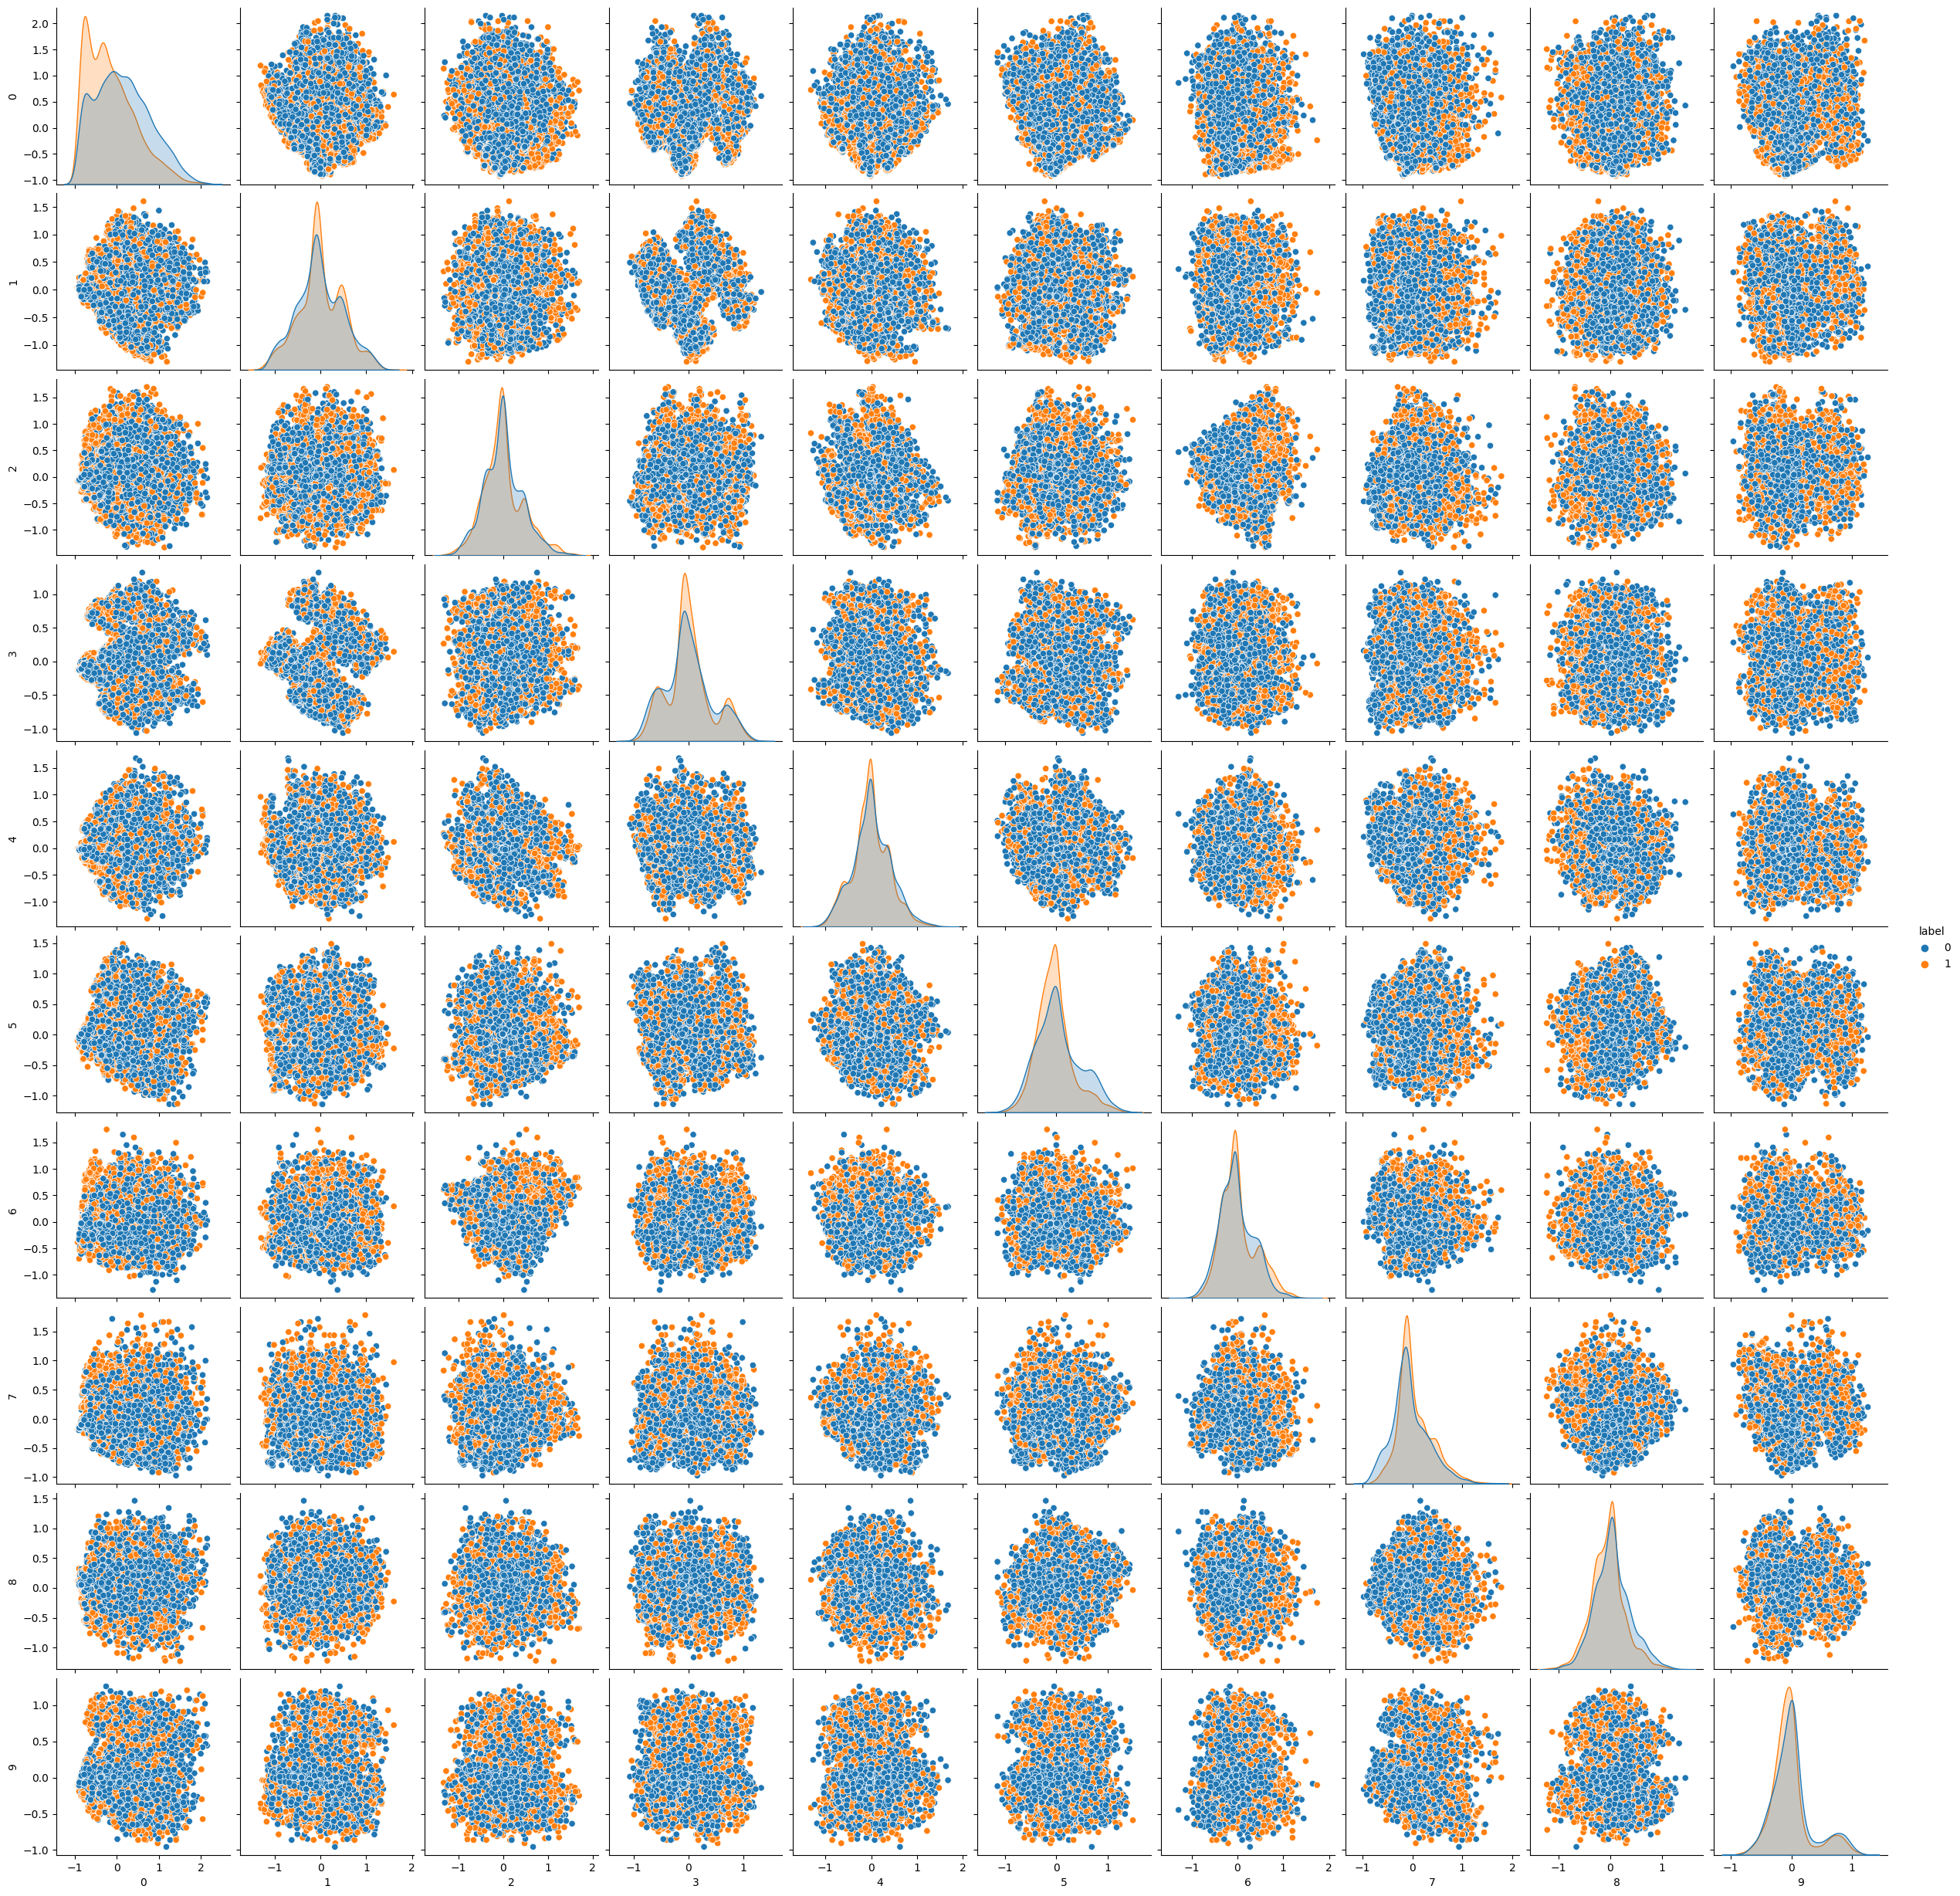

In [7]:
from sklearn.decomposition import PCA

# COMPUTE PCA WITH 10 COMPONENTS
pca = PCA(n_components=10)
pca.fit(X)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# GET PRINCIPLE COMPONENT PROJECTIONS 
principal_components = pca.fit_transform(X)
df2 = pd.DataFrame(data = principal_components) #, columns = ['PC1','PC2','PC3','PC4','PC5'])
df3=pd.concat([df2,df['label']], axis=1)

# FIRST TWO COMPONENTS
sns.scatterplot(data=df2, x=0, y=1,hue=df["label"]) 
plt.show()

#3D PLOT
ax = plt.axes(projection='3d')
ax.scatter3D(df2[0], df2[1], df2[2], c=y1);
plt.show()

#PAIRPLOT
tweet_pairplot = sns.pairplot(data=df3,hue="label") #.to_numpy()) #,hue=df["label"]) #, hue="time")
# tweet_pairplot.figure.savefig("tweet_pairplot.png")
tweet_pairplot
tweet_pairplot.figure.savefig("tweet_pairplot.png")

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score

In [9]:
# split the dataset into train and test
df_train, df_test = train_test_split(df, test_size=0.20)

In [10]:
# INITIALIZE COUNT VECTORIZER
# minDF = 0.01 means "ignore terms that appear in less than 1% of the documents". 
# minDF = 5 means "ignore terms that appear in less than 5 documents".
vectorizer=CountVectorizer(min_df=0.001)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
Xs  =  vectorizer.fit_transform(corpus)   
X=np.array(Xs.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(X,axis=0)
X=np.ceil(X/maxs)

# DOUBLE CHECK 
print(X.shape,y1.shape)
print("DATA POINT-0:",X[0,0:10],"y1 =",y1[0])

(10029, 1113) (10029,)
DATA POINT-0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] y1 = 0


In [11]:
print(y1[300:400])

[0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [12]:
from sklearn.model_selection import train_test_split
test_ratio=0.2

# SPLIT ARRAYS OR MATRICES INTO RANDOM TRAIN AND TEST SUBSETS.
x_train, x_test, y_train, y_test = train_test_split(X, y1, test_size=test_ratio, random_state=0)
y_train=y_train.flatten()
y_test=y_test.flatten()

print("x_train.shape		:",x_train.shape)
print("y_train.shape		:",y_train.shape)

print("X_test.shape		:",x_test.shape)
print("y_test.shape		:",y_test.shape)

x_train.shape		: (8023, 1113)
y_train.shape		: (8023,)
X_test.shape		: (2006, 1113)
y_test.shape		: (2006,)


In [13]:
#CHECK TO MAKE SURE IT WAS RANDOMIZED 
print(y_train[0:100])

[0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1
 1 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 1
 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 0]


In [14]:
def report(y,ypred):
      #ACCURACY COMPUTE 
      print("Accuracy:",accuracy_score(y, ypred)*100)
      print("Number of mislabeled points out of a total %d points = %d"
            % (y.shape[0], (y != ypred).sum()))

def print_model_summary():
      # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
      yp_train = model.predict(x_train)
      yp_test = model.predict(x_test)

      print("ACCURACY CALCULATION\n")

      print("TRAINING SET:")
      report(y_train,yp_train)

      print("\nTEST SET (UNTRAINED DATA):")
      report(y_test,yp_test)

      print("\nCHECK FIRST 20 PREDICTIONS")
      print("TRAINING SET:")
      print(y_train[0:20])
      print(yp_train[0:20])
      print("ERRORS:",yp_train[0:20]-y_train[0:20])

      print("\nTEST SET (UNTRAINED DATA):")
      print(y_test[0:20])
      print(yp_test[0:20])
      print("ERRORS:",yp_test[0:20]-y_test[0:20])

In [15]:
from sklearn.naive_bayes import MultinomialNB

# INITIALIZE MODEL 
model = MultinomialNB()

# TRAIN MODEL 
model.fit(x_train,y_train)

# PRINT REPORT USING UTILITY FUNCTION ABOVE
print_model_summary()

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 82.53770410071046
Number of mislabeled points out of a total 8023 points = 1401

TEST SET (UNTRAINED DATA):
Accuracy: 77.96610169491525
Number of mislabeled points out of a total 2006 points = 442

CHECK FIRST 20 PREDICTIONS
TRAINING SET:
[0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1]
[1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1]
ERRORS: [ 1  0 -1  0  0  0  0  0  0  1  1  0  0  0  1  0  0  0  0  0]

TEST SET (UNTRAINED DATA):
[0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0]
[0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 0 0 0]
ERRORS: [ 0  0  0  0  0  0  0  1  0  0  0  0  0 -1  1  0 -1  0 -1  0]


In [16]:
## Classification model-2: KNN 

## Hyper-Parameter tuning

from sklearn.neighbors import KNeighborsClassifier


# HYPER PARAMETER SEARCH FOR OPTIMAL NUMBER OF NEIGHBORS 
num_neighbors=[]
train_accuracy=[]
test_accuracy=[]

# LOOP OVER HYPER-PARAM
for i in range(1,40):
    # INITIALIZE MODEL 
    model = KNeighborsClassifier(n_neighbors=i)

    # TRAIN MODEL 
    model.fit(x_train,y_train)

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)

    print("n_neighbors =",i)
    acc1=accuracy_score(y_train, yp_train)*100
    acc2=accuracy_score(y_test, yp_test)*100

    num_neighbors.append(i)
    train_accuracy.append(acc1)
    test_accuracy.append(acc2)

    print(" train accuracy:",acc1)
    print(" test accuracy:" ,acc2)

n_neighbors = 1
 train accuracy: 99.10258008226349
 test accuracy: 68.79361914257228
n_neighbors = 2
 train accuracy: 86.0650629440359
 test accuracy: 66.6999002991027
n_neighbors = 3
 train accuracy: 84.45718559142466
 test accuracy: 67.84646061814557
n_neighbors = 4
 train accuracy: 81.78985416926336
 test accuracy: 68.39481555333998
n_neighbors = 5
 train accuracy: 79.43412688520503
 test accuracy: 68.19541375872383
n_neighbors = 6
 train accuracy: 79.6834101956874
 test accuracy: 69.0927218344965
n_neighbors = 7
 train accuracy: 77.6268228842079
 test accuracy: 69.54137587238284
n_neighbors = 8
 train accuracy: 77.61435871868379
 test accuracy: 69.39182452642075
n_neighbors = 9
 train accuracy: 76.20590801445843
 test accuracy: 68.39481555333998
n_neighbors = 10
 train accuracy: 76.71693880094728
 test accuracy: 68.74376869391826
n_neighbors = 11
 train accuracy: 74.69774398604014
 test accuracy: 68.64406779661016
n_neighbors = 12
 train accuracy: 75.28355976567369
 test accuracy: 

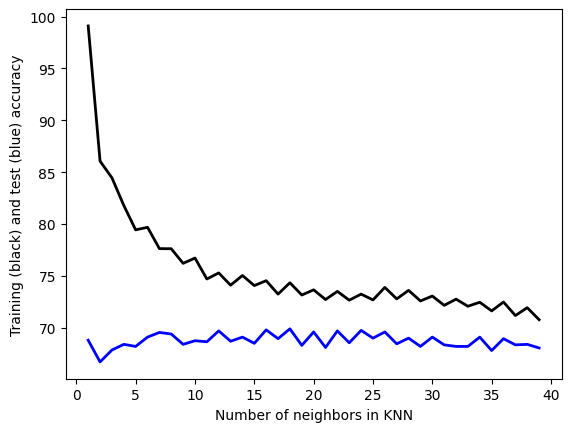

In [17]:
# Convergence plot
plt.plot(num_neighbors,train_accuracy ,linewidth=2, color='k')
plt.plot(num_neighbors,test_accuracy ,linewidth=2, color='b')

plt.xlabel("Number of neighbors in KNN")
plt.ylabel("Training (black) and test (blue) accuracy")
plt.savefig("convergence_plot.png")

In [18]:
# RETRAIN WITH OPTIMAL HYPER-PARAMETERS

# INITIALIZE MODEL 
model = KNeighborsClassifier(n_neighbors=30)

# TRAIN MODEL 
model.fit(x_train,y_train)

# PRINT REPORT USING UTILITY FUNCTION ABOVE
print_model_summary()

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 73.05247413685653
Number of mislabeled points out of a total 8023 points = 2162

TEST SET (UNTRAINED DATA):
Accuracy: 69.0927218344965
Number of mislabeled points out of a total 2006 points = 620

CHECK FIRST 20 PREDICTIONS
TRAINING SET:
[0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1]
[1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 0 0 1]
ERRORS: [1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0]

TEST SET (UNTRAINED DATA):
[0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0]
[1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0]
ERRORS: [ 1  0  0 -1 -1  0  0  1  0  0  0  0  0  0  1  0  0  1 -1  0]
